## 나스닥 데이터 로드

In [6]:
import requests
import os

csv_file = '/home/aiffel0049/aiffel/Exploration/20.anomaly_detection/nasdaq/nasdaq.csv'

In [7]:
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [8]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1073
High         1073
Low          1073
Close        1073
Adj Close    1073
Volume       1073
dtype: int64

In [9]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6172
삭제 후 데이터 길이(일자수): 5099


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

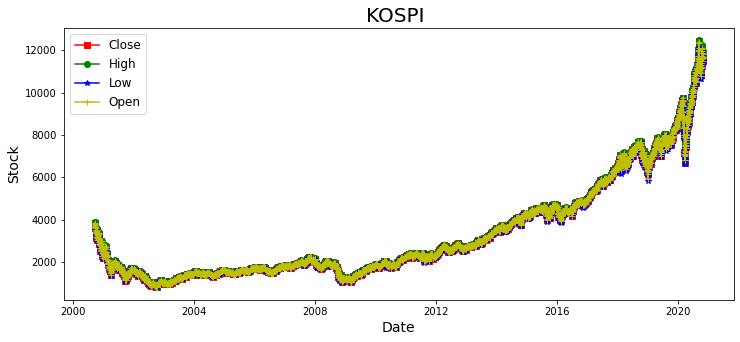

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [11]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


## 분포

### z-test

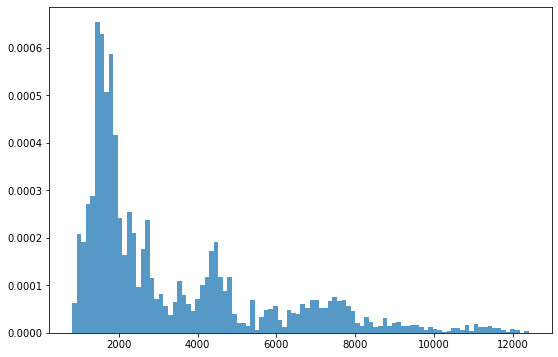

In [13]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [12]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


- 정규분포가 아님

### Time series decompose

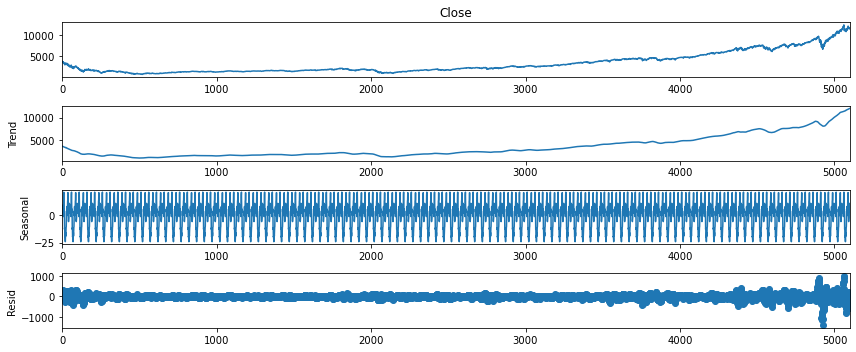

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

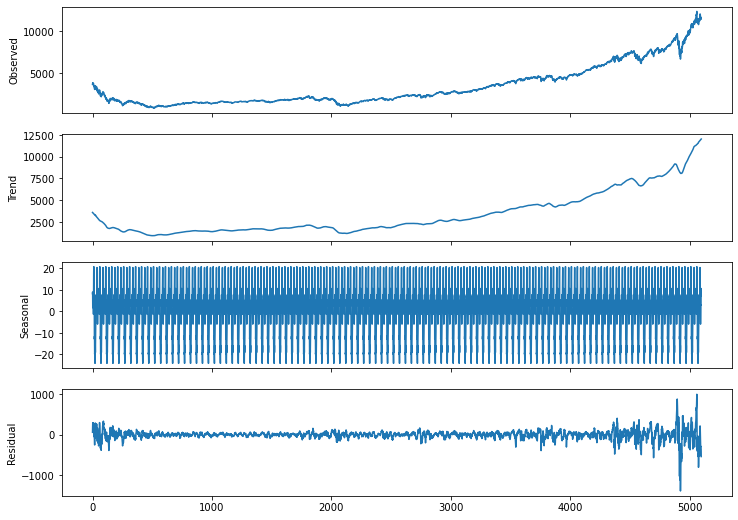

In [15]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

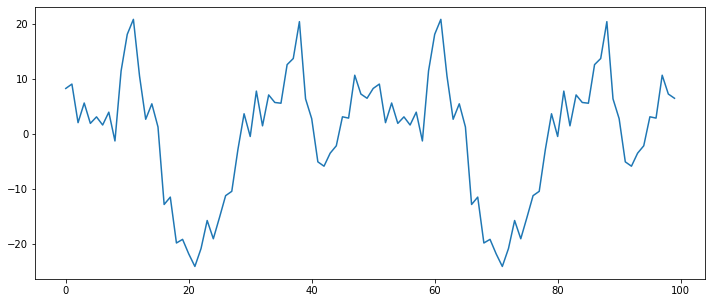

In [16]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
#-25 에서 20 사이를 주기적으로 반복하는게 보이네요.

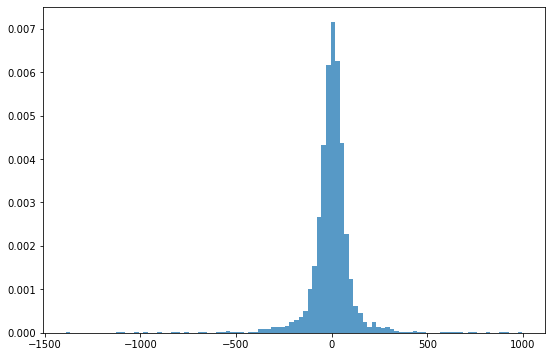

In [17]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [18]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8449533764699358 0.3981368709039024


- seasonal : 정규분포형태

### 3σ 기준 신뢰구간으로 이상치 찾기

In [20]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2999120663276504 표준편차: 109.85598825288083
이상치 갯수: 91


In [21]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5084   2020-10-06
5085   2020-10-07
5096   2020-10-22
5097   2020-10-23
5098   2020-10-26
Name: Date, Length: 91, dtype: datetime64[ns]

- 2001년 미국, 캐나다, 유럽 주식 시장의 급격한 하락(버블 붕괴라고도 부름) + 2002년 3월부터 꾸준한 하락
- 2020년에는 코로나로 인한 급격한 하락 현상을 보였음
- novelties에 해당하는 것으로 생각됨

## Unsupervised Clustering으로 이상치찾기

### 데이터 전처리

In [22]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000
mean,3332.330515,3363.855745,3300.111907,3334.217782,288130.461031
std,2403.391909,2425.438732,2382.102203,2407.330351,109938.975816
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.475000,1597.732500,1571.207500,1584.428000,220602.630000
50%,2264.890000,2292.520000,2232.222500,2265.365898,268966.970000
75%,4434.496250,4466.726250,4401.212500,4435.423750,319713.305000
max,12033.042071,12196.758183,11862.766066,12040.730510,776809.340000


- volume이 상대적으로 크므로, 정규화 진행

In [23]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.34104664  -1.42565666  -1.24553873  -1.32489327 111.32905299]


array([[ 0.95049097,  0.8474392 ,  0.81778679,  0.602076  ,  0.08324263],
       [ 0.49107995,  1.28568589,  1.38927839,  2.09633001,  0.10456865],
       [ 1.91066005,  2.02071299,  2.04939104,  2.73893222, -0.08890357],
       ...,
       [-2.82945994, -4.24460804, -2.81850532, -3.2638577 ,  0.36342897],
       [-3.12271671, -4.82026893, -2.62886854, -3.3617078 , -0.28818501],
       [-3.65110382, -4.98785578, -4.53564258, -5.03931076, -0.44039074]])

### K-means

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [25]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1104 3995]


In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:987',
 'group:1-count:823',
 'group:2-count:78',
 'group:3-count:261',
 'group:4-count:12',
 'group:5-count:20',
 'group:6-count:481',
 'group:7-count:122',
 'group:8-count:1803',
 'group:9-count:512']

#### 분석

In [28]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==2)|(kmeans.labels_==4)|(kmeans.labels_==5)]

,Date,Open,High,Low,Close,Adj Close,Volume
52,2000-11-30,2508.500000,2589.000000,2435.000000,2530.000000,2530.000000,105511.0
66,2000-12-20,2415.000000,2445.500000,2234.500000,2269.000000,2269.000000,91112.0
67,2000-12-21,2275.500000,2390.000000,2211.000000,2282.500000,2282.500000,92544.0
73,2001-01-02,2375.000000,2414.000000,2130.500000,2167.500000,2167.500000,87316.0
77,2001-01-08,2290.000000,2328.000000,2171.000000,2325.000000,2325.000000,92841.0
...,...,...,...,...,...,...,...
5094,2020-10-20,11697.500000,11792.000000,11598.500000,11660.799805,11660.799805,622702.0
5095,2020-10-21,11675.200195,11779.200195,11585.000000,11691.200195,11691.200195,599851.0
5096,2020-10-22,11683.500000,11724.000000,11511.000000,11649.799805,11649.799805,583669.0
5097,2020-10-23,11669.200195,11691.799805,11551.000000,11663.500000,11663.500000,501243.0


In [33]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==2)]

,Date,Open,High,Low,Close,Adj Close,Volume
52,2000-11-30,2508.500000,2589.000000,2435.000000,2530.000000,2530.000000,105511.0
66,2000-12-20,2415.000000,2445.500000,2234.500000,2269.000000,2269.000000,91112.0
67,2000-12-21,2275.500000,2390.000000,2211.000000,2282.500000,2282.500000,92544.0
73,2001-01-02,2375.000000,2414.000000,2130.500000,2167.500000,2167.500000,87316.0
77,2001-01-08,2290.000000,2328.000000,2171.000000,2325.000000,2325.000000,92841.0
...,...,...,...,...,...,...,...
5094,2020-10-20,11697.500000,11792.000000,11598.500000,11660.799805,11660.799805,622702.0
5095,2020-10-21,11675.200195,11779.200195,11585.000000,11691.200195,11691.200195,599851.0
5096,2020-10-22,11683.500000,11724.000000,11511.000000,11649.799805,11649.799805,583669.0
5097,2020-10-23,11669.200195,11691.799805,11551.000000,11663.500000,11663.500000,501243.0


In [34]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==4)]

,Date,Open,High,Low,Close,Adj Close,Volume
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.000000,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.000000,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.000000,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.000000,7392.250000,6830.000000,7225.250000,7225.250000,156283.0
4922,2020-03-19,7251.750000,7521.500000,6894.250000,7293.500000,7293.500000,115519.0
4923,2020-03-20,7195.000000,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4924,2020-03-22,6798.000000,6798.000000,6628.750000,6688.750000,6688.750000,321230.0
4925,2020-03-23,6798.000000,7316.250000,6628.750000,6984.500000,6984.500000,633237.0
4926,2020-03-24,7005.750000,7572.250000,7005.750000,7554.750000,7554.750000,556553.0


In [35]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==5)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


#### 그룹별 특징

In [32]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.531319,-0.550213,-0.495152,-0.499480,0.121391
1,0.725290,0.753358,0.775464,0.771376,-0.323672
2,-3.268460,-3.550487,-3.283966,-3.321055,0.472842
3,-1.345277,-1.373697,-1.506878,-1.465911,1.166038
4,-8.386746,-7.477276,-8.372639,-7.465361,-2.106296
5,6.090400,6.133137,6.131821,6.050440,-0.221921
6,-0.053415,-0.067209,0.021495,0.002236,-1.613879
7,2.263931,2.330929,2.349586,2.290812,-0.261411
8,0.112485,0.120750,0.133055,0.129428,-0.038131
9,0.106623,0.099985,-0.123898,-0.097515,1.388387


- 2 : 다른 그룹보다 Open, High, Low, Close 값이 낮음
- 4 : 다른 그룹보다 Open, High, Low, Close 값이 낮음
- 5 : 다른 그룹보다 Open, High, Low, Close 값이 높음

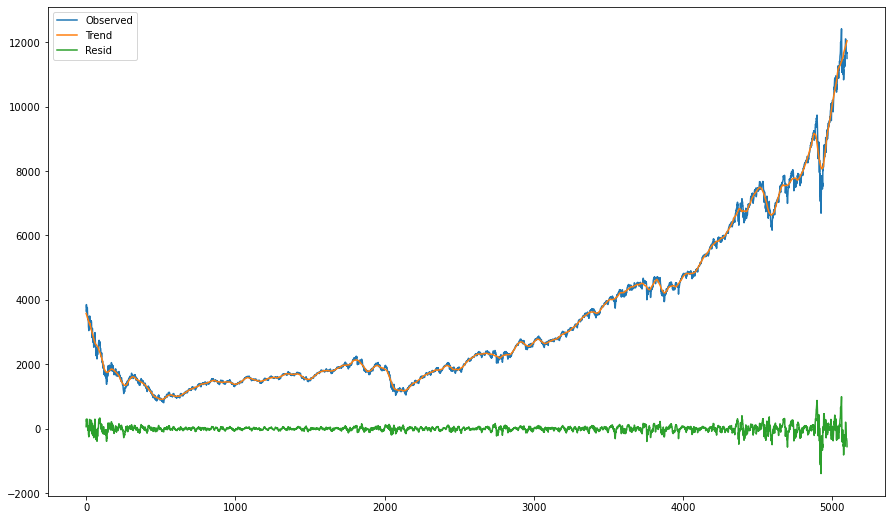

In [36]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

### DBSCAN

In [37]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [38]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ... -1 -1 -1]


In [39]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:200',
 'group:0-count:4842',
 'group:1-count:2',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:3',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:3',
 'group:21-count:2',
 'group:22-count:2']

In [45]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(clustering.labels_!=-1) & (clustering.labels_!=0)]

,Date,Open,High,Low,Close,Adj Close,Volume
41,2000-11-14,2826.000000,3068.000000,2825.000000,3057.500000,3057.500000,72323.0
52,2000-11-30,2508.500000,2589.000000,2435.000000,2530.000000,2530.000000,105511.0
55,2000-12-05,2563.000000,2857.000000,2530.000000,2840.000000,2840.000000,93557.0
65,2000-12-19,2609.500000,2686.000000,2393.000000,2410.000000,2410.000000,83019.0
66,2000-12-20,2415.000000,2445.500000,2234.500000,2269.000000,2269.000000,91112.0
67,2000-12-21,2275.500000,2390.000000,2211.000000,2282.500000,2282.500000,92544.0
76,2001-01-05,2485.000000,2551.000000,2273.500000,2293.500000,2293.500000,94688.0
77,2001-01-08,2290.000000,2328.000000,2171.000000,2325.000000,2325.000000,92841.0
136,2001-04-03,1521.500000,1527.000000,1402.000000,1405.000000,1405.000000,132338.0
137,2001-04-04,1407.500000,1451.000000,1361.000000,1379.500000,1379.500000,141811.0


#### 분석
- 2001년 미국, 캐나다, 유럽 주식 시장의 급격한 하락(버블 붕괴라고도 부름) + 2002년 3월부터 꾸준한 하락
- 2020년에는 코로나로 인한 급격한 하락 현상을 보였음
- novelties에 해당하는 것으로 생각됨   

- thescoop.co.kr/news/articleView.html?idxno=33260
- 2018년 2월 : 금리인상 가능성에 흔들림
- 2018년 6월 : 미중 무역전쟁 우려
- 2018년 10월 : 2019년 글로벌 경기둔화 가능성
- 2018년 12월 : 미 행정부의 정치 불안

## Auto encoder

In [46]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [47]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [48]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

### 데이터셋 제작
- TimeseriesGenerator
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator
- data : 입력데이터(x)를 넣어줍니다. 우리는 'Open','High','Low','Close','Volume' 5가지 인풋을 사용합니다.
- targets : 출력데이터를 넣어줍니다. 우리는 5가지 인풋 그대로 예측하기 때문에 data와 동일한걸 넣어줍니다.
- length : 몇개의 time_step을 참고할지 입력합니다.
- stride : time_step 사이즈를 결정합니다.

In [50]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


### 모델만들기
- 2개 층의 LSTM으로 인코더 제작
- RepeatVector는 input을 window_size만큼 복사

In [104]:
model = Sequential([
    # >> 인코더 시작
    LSTM(32, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(8, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(8, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10, 32)            4864      
_________________________________________________________________
lstm_25 (LSTM)               (None, 8)                 1312      
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 10, 8)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 10, 8)             544       
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                5248      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 12,133
Trainable params: 12,133
Non-trainable params: 0
__________________________________________________

In [105]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = '/home/aiffel0049/aiffel/Exploration/20.anomaly_detection/nasdaq/mymodel_2.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [106]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/160 [============================>.] - ETA: 0s - loss: 1.9879 - mae: 1.9879
Epoch 00001: val_loss improved from inf to 4.93623, saving model to /home/aiffel0049/aiffel/Exploration/20.anomaly_detection/nasdaq/mymodel_2.ckpt
160/160 [==============================] - 5s 30ms/step - loss: 1.9770 - mae: 1.9770 - val_loss: 4.9362 - val_mae: 4.9362
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 1.0771 - mae: 1.0771
Epoch 00002: val_loss improved from 4.93623 to 1.61206, saving model to /home/aiffel0049/aiffel/Exploration/20.anomaly_detection/nasdaq/mymodel_2.ckpt
160/160 [==============================] - 5s 28ms/step - loss: 1.0718 - mae: 1.0718 - val_loss: 1.6121 - val_mae: 1.6121
Epoch 3/50
159/160 [============================>.] - ETA: 0s - loss: 0.6401 - mae: 0.6401
Epoch 00003: val_loss improved from 1.61206 to 0.95146, saving model to /home/aiffel0049/aiffel/Exploration/20.anomaly_detection/nasdaq/mymodel_2.ckpt
160/160 [=========================

In [107]:
model.load_weights(checkpoint_path)

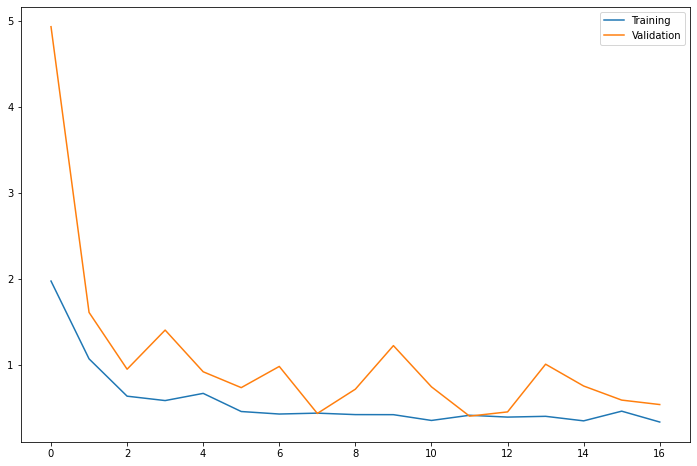

In [108]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

### 분석

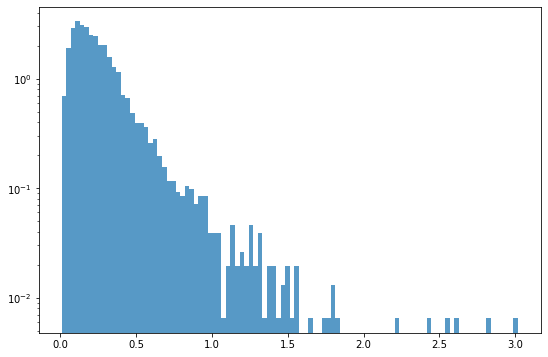

In [109]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [110]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

In [111]:
threshold = 1
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1747,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.140060
1806,2007-11-08,2175.000000,2180.000000,2081.000000,2105.500000,2105.500000,884081.0,1.039836
3534,2014-10-15,3823.750000,3831.500000,3691.250000,3752.000000,3752.000000,831107.0,1.268629
3535,2014-10-16,3751.000000,3786.500000,3684.000000,3741.500000,3741.500000,695840.0,1.031803
3747,2015-08-24,4183.750000,4196.250000,3908.250000,4003.250000,4003.250000,746533.0,1.205812
...,...,...,...,...,...,...,...,...
5051,2020-09-02,12325.500000,12465.200195,12172.200195,12411.500000,12411.500000,725395.0,1.429566
5052,2020-09-03,12408.500000,12438.799805,11658.500000,11800.500000,11800.500000,931583.0,1.474505
5053,2020-09-04,11745.000000,11843.000000,11142.000000,11548.799805,11548.799805,1202274.0,1.365904
5078,2020-10-12,11722.799805,12197.000000,11687.799805,12098.200195,12098.200195,756438.0,1.024882


/home/aiffel0049/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


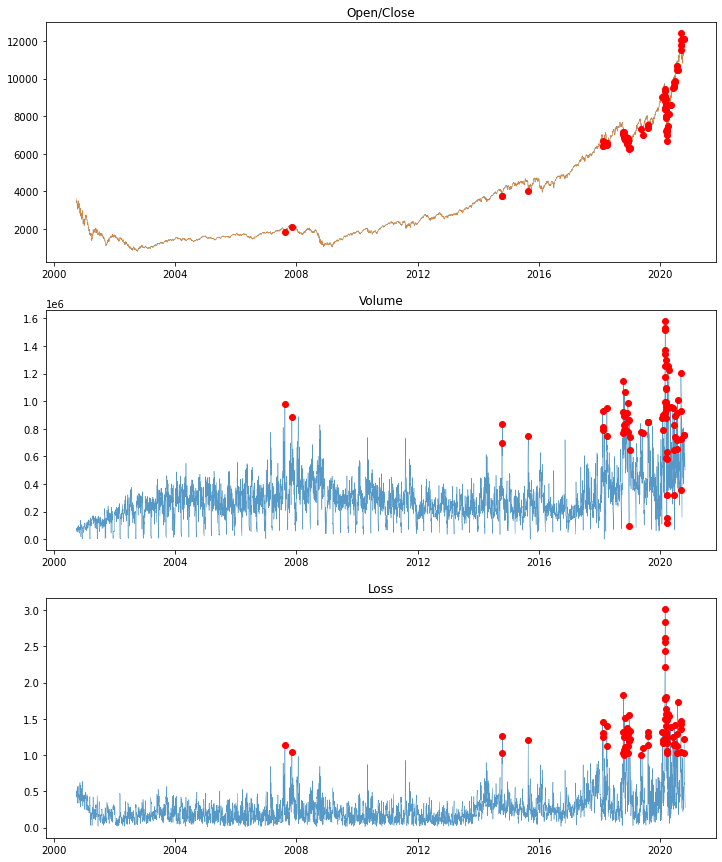

In [112]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

### 실험

1. 기본
    64, 16, 16, 64
    
2. 모델 수정
    32, 16, 16, 32
    
3. 모델 수정
    128, 32, 32, 128

4. 모델 수정
    128, 64, 16, 16, 64, 128

5. 모델 수정
    32, 8, 8, 32